Trying to predict if a pair of compounds is a MAIN pair

In [34]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/pairs_final_RPAIRS_smiles.csv', index_col=0)
display(df.head())

# keep rows with 'RPAIR_main' !=2
df_train = df[df['RPAIR_main'] != 2]
df_test = df[df['RPAIR_main'] == 2]

print(f'Train: {df_train.shape}, Test: {df_test.shape} \n')

# count values in 'RPAIR_main'
print('RPAIR value counts:', df_train['RPAIR_main'].value_counts(normalize=True).round(2))

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,RPAIR_main
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train: (21071, 2049), Test: (34909, 2049) 

RPAIR value counts: RPAIR_main
1    0.53
0    0.47
Name: proportion, dtype: float64


In [35]:
# split df_train to X and y
X = df_train.drop('RPAIR_main', axis=1)
y = df_train['RPAIR_main'].copy()

# split df_train into train and validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(16856, 2048) (4215, 2048) (16856,) (4215,)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.953 total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.955 total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.951 total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.956 total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.957 total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.954 total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.934 total time=   4.6s
[CV 

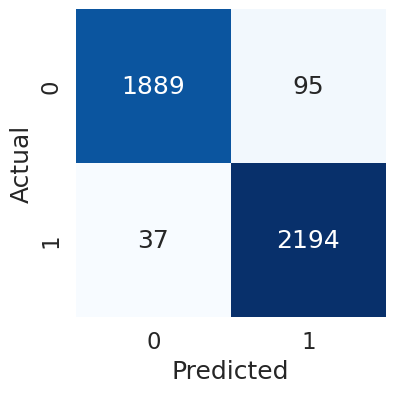

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_clf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid, n_iter=10, cv=3, verbose=3,
                                 random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# evaluate the best model
best_model = rf_random.best_estimator_
y_pred = best_model.predict(X_val)
accuracy_score(y_val, y_pred)

# get confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [39]:
# predict on test set
y_test = best_model.predict(df_test.drop('RPAIR_main', axis=1))
df_test['RPAIR_main'] = y_test
display(df_test.head())
print(df_test['RPAIR_main'].value_counts(normalize=True).round(2))

/tmp/ipykernel_520045/2950201150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['RPAIR_main'] = y_test


,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,RPAIR_main
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,2,0,0,0,0,2,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


RPAIR_main
0    0.74
1    0.26
Name: proportion, dtype: float64


In [42]:
# concat df_train and df_test to df_final and sort by index
df_final = pd.concat([df_train, df_test]).sort_index()

print(df_final.shape, df.shape)

(55980, 2049) (55980, 2049)


In [46]:
# read 'pairs_final_RPAIRS.csv'
pairs = pd.read_csv('data/pairs_final_RPAIRS.csv', index_col=0)

# add 'RPAIR_main' column to 'pairs_final_RPAIRS.csv'
pairs['RPAIR_main_pred'] = df_final['RPAIR_main'].values
pairs.head()

# save 'pairs_final_RPAIRS.csv'
pairs.to_csv('data/pairs_final_RPAIRS_pred.csv')